<a href="https://colab.research.google.com/github/Donggeon2960/623_chungnam/blob/main/0710_opencv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# 1.필요한 라이브러리 임포트
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML, display
from google.colab.patches import cv2_imshow
import os

# OpenCV 버전 확인
print(f"OpenCV 버전: {cv2.__version__}")

# 영상 파일 경로 설정 (예시)
video_path = '/content/김영빈_영상.mp4'

# 2. yt-dlp 설치
!pip install yt-dlp

# 원하는 유튜브 영상 다운로드
!yt-dlp -f bestvideo+bestaudio --merge-output-format mp4 https://www.youtube.com/watch?v=tEtWnGwwCEc
# 3.
import cv2
import yt_dlp
import matplotlib.pyplot as plt
import tempfile
import os
import time
from IPython.display import clear_output

def play_youtube_video(youtube_url, skip_frames=1):
    """
    YouTube 영상을 다운로드하고 재생하는 간단한 함수
    skip_frames: 프레임 건너뛰기 (1=모든 프레임, 2=한 프레임씩 건너뛰기)
    """

    ydl_opts = {
        'format': 'mp4/best[height<=480]',  # 480p로 제한 (빠른 처리)
        'outtmpl': tempfile.gettempdir() + '/temp_video.%(ext)s',
        'quiet': True,
    }

    try:
        with yt_dlp.YoutubeDL(ydl_opts) as ydl:
            print("⬇️ 영상 다운로드 중...")
            info = ydl.extract_info(youtube_url, download=True)

            video_path = ydl.prepare_filename(info)

            cap = cv2.VideoCapture(video_path)
            fps = cap.get(cv2.CAP_PROP_FPS)
            frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

            print(f"🎬 '{info['title']}' 재생 시작!")
            print("(Ctrl+C로 중단)")

            frame_num = 0
            while True:
                ret, frame = cap.read()
                if not ret:
                    break

                # 프레임 건너뛰기
                if frame_num % skip_frames == 0:
                    clear_output(wait=True)
                    plt.figure(figsize=(10, 6))
                    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
                    plt.title(f"재생 중... ({frame_num}/{frame_count})")
                    plt.axis('off')
                    plt.show()

                    # 재생 속도 조절
                    time.sleep(0.1)  # 0.1초 대기 (빠른 재생)

                frame_num += 1

            cap.release()
            os.remove(video_path)
            print("✅ 재생 완료!")

    except KeyboardInterrupt:
        print("\n⏹️ 재생 중단")
    except Exception as e:
        print(f"❌ 오류: {e}")

# 사용법
youtube_url = input("YouTube URL: ")
play_youtube_video(youtube_url, skip_frames=2)  # 한 프레임씩 건너뛰어 빠른 재생


# 4. 개선된 차선 인식 및 영상 저장 코드
import cv2
from google.colab import files
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
import time

# 영상 업로드
#uploaded = files.upload()
video_path = "/content/sample_data/around5.mp4"

# 영상 열기
cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

print(f"📹 영상 정보: {frame_count}프레임, {fps:.2f}FPS, {width}x{height}")
print("🎬 차선 인식 시작! (Ctrl+C로 중단)")

# 1. 영상 저장 설정
output_path = '/content/lane_detection_result.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

# 2. 프레임 저장용 리스트
saved_frames = []

# 차선 분류 함수 추가
def classify_lines(lines, img_width):
    """차선을 왼쪽, 오른쪽으로 분류"""
    left_lines = []
    right_lines = []

    if lines is None:
        return left_lines, right_lines

    for line in lines:
        x1, y1, x2, y2 = line[0]
        slope = (y2 - y1) / (x2 - x1) if x2 != x1 else 0

        # 기울기와 위치로 왼쪽/오른쪽 차선 구분
        if slope < -0.3 and x1 < img_width / 2:  # 왼쪽 차선 (음의 기울기)
            left_lines.append(line)
        elif slope > 0.3 and x1 > img_width / 2:  # 오른쪽 차선 (양의 기울기)
            right_lines.append(line)

    return left_lines, right_lines

def average_slope_intercept(lines):
    """선분들의 평균 기울기와 절편 계산"""
    if not lines:
        return None

    slopes = []
    intercepts = []

    for line in lines:
        x1, y1, x2, y2 = line[0]
        if x2 != x1:
            slope = (y2 - y1) / (x2 - x1)
            intercept = y1 - slope * x1
            slopes.append(slope)
            intercepts.append(intercept)

    if not slopes:
        return None

    avg_slope = np.mean(slopes)
    avg_intercept = np.mean(intercepts)

    return avg_slope, avg_intercept

def make_line_points(y1, y2, line_params):
    """기울기와 절편으로 선분의 시작점과 끝점 계산"""
    if line_params is None:
        return None

    slope, intercept = line_params
    x1 = int((y1 - intercept) / slope)
    x2 = int((y2 - intercept) / slope)

    return [[x1, y1, x2, y2]]

frame_num = 0
try:
    while True:
        ret, frame = cap.read()
        if not ret:
            print("📺 영상 재생 완료")
            break

        # 1. 그레이스케일 변환
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # 2. 블러 → 에지(Canny) - 임계값 조정
        blur = cv2.GaussianBlur(gray, (5, 5), 0)
        edges = cv2.Canny(blur, 50, 150)  # 임계값 조정

        # 3. ROI 설정 - 하단 영역에 집중
        roi_height, roi_width = edges.shape
        mask = np.zeros_like(edges)
        polygon = np.array([[
            (int(roi_width * 0.1), roi_height),            # 왼쪽 아래
            (int(roi_width * 0.9), roi_height),            # 오른쪽 아래
            (int(roi_width * 0.55), int(roi_height * 0.6)), # 오른쪽 위
            (int(roi_width * 0.45), int(roi_height * 0.6))  # 왼쪽 위
        ]])
        cv2.fillPoly(mask, polygon, 255)
        roi = cv2.bitwise_and(edges, mask)

        # 4. Hough Transform으로 직선 검출 - 파라미터 최적화
        lines = cv2.HoughLinesP(roi, 1, np.pi / 180,
                               threshold=20,      # 임계값 낮춤
                               minLineLength=20,  # 최소 선분 길이
                               maxLineGap=300)    # 최대 간격 증가

        # 5. 차선 분류 및 평균선 계산
        line_image = frame.copy()
        if lines is not None:
            left_lines, right_lines = classify_lines(lines, roi_width)

            # 평균 차선 계산
            left_line_params = average_slope_intercept(left_lines)
            right_line_params = average_slope_intercept(right_lines)

            # 차선 그리기
            y1 = roi_height
            y2 = int(roi_height * 0.6)

            left_line_points = make_line_points(y1, y2, left_line_params)
            right_line_points = make_line_points(y1, y2, right_line_params)

            # 왼쪽 차선 그리기 (빨간색)
            if left_line_points:
                x1, y1, x2, y2 = left_line_points[0]
                cv2.line(line_image, (x1, y1), (x2, y2), (0, 0, 255), 8)

            # 오른쪽 차선 그리기 (파란색)
            if right_line_points:
                x1, y1, x2, y2 = right_line_points[0]
                cv2.line(line_image, (x1, y1), (x2, y2), (255, 0, 0), 8)

            # 원본 선분들도 표시 (얇은 녹색선)
            for line in lines:
                x1, y1, x2, y2 = line[0]
                cv2.line(line_image, (x1, y1), (x2, y2), (0, 255, 0), 2)

        # 영상에 저장
        out.write(line_image)

        # 2. 프레임 저장 (10프레임마다)
        if frame_num % 10 == 0:
            saved_frames.append(line_image.copy())

        # 6. 결과 출력 (30프레임마다)
        if frame_num % 30 == 0:
            clear_output(wait=True)
            plt.figure(figsize=(15, 8))
            plt.subplot(1, 3, 1)
            plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            plt.title(f"원본 프레임 {frame_num}")
            plt.axis('off')

            plt.subplot(1, 3, 2)
            plt.imshow(edges, cmap='gray')
            plt.title("에지 검출 결과")
            plt.axis('off')

            plt.subplot(1, 3, 3)
            plt.imshow(cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB))
            plt.title(f"차선 인식 결과 ({len(lines) if lines is not None else 0}개)")
            plt.axis('off')
            plt.tight_layout()
            plt.show()

        frame_num += 1

        # 처리 속도 조절 (선택사항)
        # time.sleep(0.1)

except KeyboardInterrupt:
    print("\n⏹️ 재생 중단")

# 3. output 리소스 정리
cap.release()
out.release()
cv2.destroyAllWindows()

# 4. 결과 영상을 /content/lane_detection_result.mp4에 다운로드
print(f"✅ 차선 인식 완료! 총 {frame_num}프레임 처리")
print(f"📁 결과 영상 저장 위치: {output_path}")
print(f"💾 저장된 프레임 수: {len(saved_frames)}개")

# 결과 영상 다운로드
if os.path.exists(output_path):
    print("📥 결과 영상 다운로드 시작...")
    files.download(output_path)
    print("✅ 다운로드 완료!")
else:
    print("❌ 결과 영상 파일을 찾을 수 없습니다.")

# 최종 통계 출력
print("\n📊 처리 결과:")
print(f"   - 입력 영상: {video_path}")
print(f"   - 출력 영상: {output_path}")
print(f"   - 처리 프레임: {frame_num}개")
print(f"   - 영상 해상도: {width}x{height}")
print(f"   - FPS: {fps:.2f}")


⏹️ 재생 중단
📹 영상 정보: 0프레임, 0.00FPS, 0x0
🎬 차선 인식 시작! (Ctrl+C로 중단)
📺 영상 재생 완료
✅ 차선 인식 완료! 총 0프레임 처리
📁 결과 영상 저장 위치: /content/lane_detection_result.mp4
💾 저장된 프레임 수: 0개
❌ 결과 영상 파일을 찾을 수 없습니다.

📊 처리 결과:
   - 입력 영상: /content/sample_data/around5.mp4
   - 출력 영상: /content/lane_detection_result.mp4
   - 처리 프레임: 0개
   - 영상 해상도: 0x0
   - FPS: 0.00


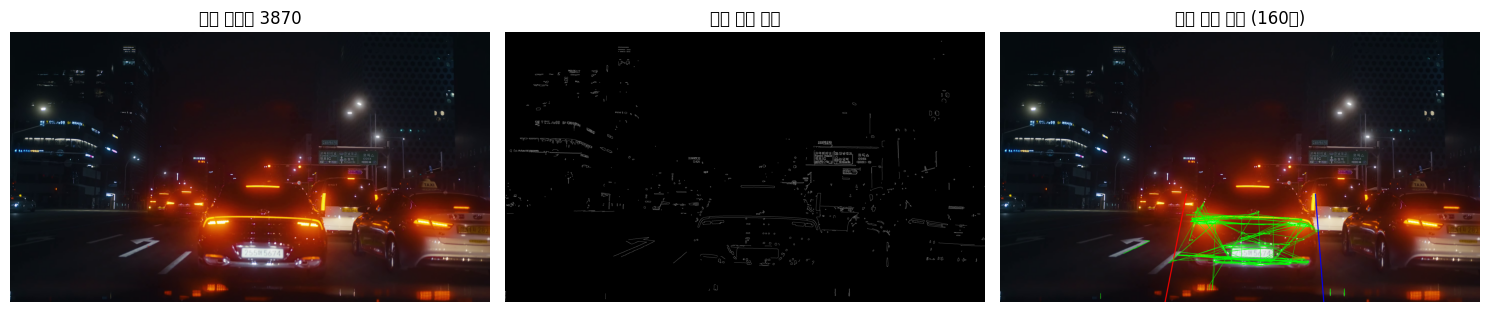

📺 영상 재생 완료
✅ 차선 인식 완료! 총 3876프레임 처리
📁 결과 영상 저장 위치: /content/lane_detection_result.mp4
💾 저장된 프레임 수: 388개
📥 결과 영상 다운로드 시작...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ 다운로드 완료!

📊 처리 결과:
   - 입력 영상: /content/강남대로 강남역 도로 드라이브 최근 밤거리 모습 입니다. [tEtWnGwwCEc].mp4
   - 출력 영상: /content/lane_detection_result.mp4
   - 처리 프레임: 3876개
   - 영상 해상도: 3840x2160
   - FPS: 23.98


In [4]:
# 4. 개선된 차선 인식 및 영상 저장 코드
import cv2
from google.colab import files
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
import time

# 영상 업로드
#uploaded = files.upload()
video_path = "/content/강남대로 강남역 도로 드라이브 최근 밤거리 모습 입니다. [tEtWnGwwCEc].mp4"

# 영상 열기
cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

print(f"📹 영상 정보: {frame_count}프레임, {fps:.2f}FPS, {width}x{height}")
print("🎬 차선 인식 시작! (Ctrl+C로 중단)")

# 1. 영상 저장 설정
output_path = '/content/lane_detection_result.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

# 2. 프레임 저장용 리스트
saved_frames = []

# 차선 분류 함수 추가
def classify_lines(lines, img_width):
    """차선을 왼쪽, 오른쪽으로 분류"""
    left_lines = []
    right_lines = []

    if lines is None:
        return left_lines, right_lines

    for line in lines:
        x1, y1, x2, y2 = line[0]
        slope = (y2 - y1) / (x2 - x1) if x2 != x1 else 0

        # 기울기와 위치로 왼쪽/오른쪽 차선 구분
        if slope < -0.3 and x1 < img_width / 2:  # 왼쪽 차선 (음의 기울기)
            left_lines.append(line)
        elif slope > 0.3 and x1 > img_width / 2:  # 오른쪽 차선 (양의 기울기)
            right_lines.append(line)

    return left_lines, right_lines

def average_slope_intercept(lines):
    """선분들의 평균 기울기와 절편 계산"""
    if not lines:
        return None

    slopes = []
    intercepts = []

    for line in lines:
        x1, y1, x2, y2 = line[0]
        if x2 != x1:
            slope = (y2 - y1) / (x2 - x1)
            intercept = y1 - slope * x1
            slopes.append(slope)
            intercepts.append(intercept)

    if not slopes:
        return None

    avg_slope = np.mean(slopes)
    avg_intercept = np.mean(intercepts)

    return avg_slope, avg_intercept

def make_line_points(y1, y2, line_params):
    """기울기와 절편으로 선분의 시작점과 끝점 계산"""
    if line_params is None:
        return None

    slope, intercept = line_params
    x1 = int((y1 - intercept) / slope)
    x2 = int((y2 - intercept) / slope)

    return [[x1, y1, x2, y2]]

frame_num = 0
try:
    while True:
        ret, frame = cap.read()
        if not ret:
            print("📺 영상 재생 완료")
            break

        # 1. 그레이스케일 변환
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # 2. 블러 → 에지(Canny) - 임계값 조정
        blur = cv2.GaussianBlur(gray, (5, 5), 0)
        edges = cv2.Canny(blur, 50, 150)  # 임계값 조정

        # 3. ROI 설정 - 하단 영역에 집중
        roi_height, roi_width = edges.shape
        mask = np.zeros_like(edges)
        polygon = np.array([[
            (int(roi_width * 0.1), roi_height),            # 왼쪽 아래
            (int(roi_width * 0.9), roi_height),            # 오른쪽 아래
            (int(roi_width * 0.55), int(roi_height * 0.6)), # 오른쪽 위
            (int(roi_width * 0.45), int(roi_height * 0.6))  # 왼쪽 위
        ]])
        cv2.fillPoly(mask, polygon, 255)
        roi = cv2.bitwise_and(edges, mask)

        # 4. Hough Transform으로 직선 검출 - 파라미터 최적화
        lines = cv2.HoughLinesP(roi, 1, np.pi / 180,
                               threshold=20,      # 임계값 낮춤
                               minLineLength=20,  # 최소 선분 길이
                               maxLineGap=300)    # 최대 간격 증가

        # 5. 차선 분류 및 평균선 계산
        line_image = frame.copy()
        if lines is not None:
            left_lines, right_lines = classify_lines(lines, roi_width)

            # 평균 차선 계산
            left_line_params = average_slope_intercept(left_lines)
            right_line_params = average_slope_intercept(right_lines)

            # 차선 그리기
            y1 = roi_height
            y2 = int(roi_height * 0.6)

            left_line_points = make_line_points(y1, y2, left_line_params)
            right_line_points = make_line_points(y1, y2, right_line_params)

            # 왼쪽 차선 그리기 (빨간색)
            if left_line_points:
                x1, y1, x2, y2 = left_line_points[0]
                cv2.line(line_image, (x1, y1), (x2, y2), (0, 0, 255), 8)

            # 오른쪽 차선 그리기 (파란색)
            if right_line_points:
                x1, y1, x2, y2 = right_line_points[0]
                cv2.line(line_image, (x1, y1), (x2, y2), (255, 0, 0), 8)

            # 원본 선분들도 표시 (얇은 녹색선)
            for line in lines:
                x1, y1, x2, y2 = line[0]
                cv2.line(line_image, (x1, y1), (x2, y2), (0, 255, 0), 2)

        # 영상에 저장
        out.write(line_image)

        # 2. 프레임 저장 (10프레임마다)
        if frame_num % 10 == 0:
            saved_frames.append(line_image.copy())

        # 6. 결과 출력 (30프레임마다)
        if frame_num % 30 == 0:
            clear_output(wait=True)
            plt.figure(figsize=(15, 8))
            plt.subplot(1, 3, 1)
            plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            plt.title(f"원본 프레임 {frame_num}")
            plt.axis('off')

            plt.subplot(1, 3, 2)
            plt.imshow(edges, cmap='gray')
            plt.title("에지 검출 결과")
            plt.axis('off')

            plt.subplot(1, 3, 3)
            plt.imshow(cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB))
            plt.title(f"차선 인식 결과 ({len(lines) if lines is not None else 0}개)")
            plt.axis('off')
            plt.tight_layout()
            plt.show()

        frame_num += 1

        # 처리 속도 조절 (선택사항)
        # time.sleep(0.1)

except KeyboardInterrupt:
    print("\n⏹️ 재생 중단")

# 3. output 리소스 정리
cap.release()
out.release()
cv2.destroyAllWindows()

# 4. 결과 영상을 /content/lane_detection_result.mp4에 다운로드
print(f"✅ 차선 인식 완료! 총 {frame_num}프레임 처리")
print(f"📁 결과 영상 저장 위치: {output_path}")
print(f"💾 저장된 프레임 수: {len(saved_frames)}개")

# 결과 영상 다운로드
if os.path.exists(output_path):
    print("📥 결과 영상 다운로드 시작...")
    files.download(output_path)
    print("✅ 다운로드 완료!")
else:
    print("❌ 결과 영상 파일을 찾을 수 없습니다.")

# 최종 통계 출력
print("\n📊 처리 결과:")
print(f"   - 입력 영상: {video_path}")
print(f"   - 출력 영상: {output_path}")
print(f"   - 처리 프레임: {frame_num}개")
print(f"   - 영상 해상도: {width}x{height}")
print(f"   - FPS: {fps:.2f}")